## Install Kaggle Library

In [2]:
!pip install kaggle

## Upload the kaggle.json file

In [3]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Importing Twitter Sentiment dataset

In [4]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

 80% 65.0M/80.9M [00:00<00:00, 88.3MB/s]
100% 80.9M/80.9M [00:00<00:00, 105MB/s] 


## About Dataset ##
### Context ###
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

### Content ###
It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2. ids: The id of the tweet ( 2087)

3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5. user: the user that tweeted (robotickilldozr)

6. text: the text of the tweet (Lyx is cool)

## Extracting the zipped dataset

In [5]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted: ")

The dataset is extracted: 


## Import the libraries

In [6]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
#Printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We remove these stopwords from our dataset as these are not meaningful for processing of the data. and reduce the complexity of the data

## **Data Processing**

In [9]:
#Loading data from csv file to pandas dataframe
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [10]:
#Checking the number of rows and columns
twitter_data.shape

(1599999, 6)

In [11]:
#Printing the first 5 rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [12]:
#Naming the column names
columns_names = ['target', 'id', 'data', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = columns_names, encoding = 'ISO-8859-1')
twitter_data.head()

,target,id,data,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Here, in target 0 means negative tweet, 2 means neutral tweet and 4 means positive tweet.

In [13]:
twitter_data.shape

(1600000, 6)

Now shape will give as 1600000 as now first row is name of the column

In [14]:
#Counting the number of missing values in the dataset
twitter_data.isnull().sum()

target    0
id        0
data      0
flag      0
user      0
text      0
dtype: int64

No missing values in the dataset

In [15]:
# Check the distribution of target column
twitter_data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Here we see equal number of positive and negative tweets.

Convert the Target "4" to "1"

In [16]:
twitter_data.replace({'target':{4:1}}, inplace=True)
twitter_data['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

0 --> Negative Tweeet

1 --> Positive Tweet

## **Stemming**

Stemming is the process of reducing a word to its Root word

Example: Actor, actress, acting = act

In [17]:
#We call the PorterStemmer function
port_stem = PorterStemmer()

In [18]:
#In the content we pass the text column for the processing
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]', ' ', content) #here we remove special charachters from the tweet
  stemmed_content = stemmed_content.lower() #Here we convert all text into lowercase
  stemmed_content = stemmed_content.split() #Here we are splitting all the words and put it into a list
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #If it is not stopword we perfrom stemming operation
  stemmed_content = ' '.join(stemmed_content) #Now we join the seperate words to form a sentence

  return stemmed_content

In [19]:
#We create a new column which contains the stemmed text
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming) #Takes about 50 minutes to process these data

In [20]:
twitter_data.head()

,target,id,data,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [21]:
#print just the stemmed_column content
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [22]:
#Print the target column
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


We don't need other columns except the tweets and the target, so we remove them

In [23]:
#Seperating the data and label
X = twitter_data['stemmed_content'].values
y = twitter_data['target'].values

In [24]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [26]:
print(y)

[0 0 0 ... 1 1 1]


## **Splitting the data into Training and Testing data**

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
#Stratify is used to make equal training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [29]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [30]:
print(y.shape, y_train.shape, y_test.shape)

(1600000,) (1280000,) (320000,)


In [31]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [32]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [33]:
print(y_train)

[1 1 0 ... 1 1 0]


## **Feature Extraction**
Converting the textual data into numerical data

In [34]:
# Import the Library
from sklearn.feature_extraction.text import TfidfVectorizer

# Calls the TfidfVectorizer method
vectorizer = TfidfVectorizer()

# Converts the training and testing text into numerical value and assigns some values to the text data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [35]:
print(X_train)

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

In [36]:
print(X_train.shape)

(1280000, 461488)


In [37]:
print(X_test)

  (0, 420984)	0.17915624523539803
  (0, 409143)	0.31430470598079707
  (0, 398906)	0.3491043873264267
  (0, 388348)	0.21985076072061738
  (0, 279082)	0.1782518010910344
  (0, 271016)	0.4535662391658828
  (0, 171378)	0.2805816206356073
  (0, 138164)	0.23688292264071403
  (0, 132364)	0.25525488955578596
  (0, 106069)	0.3655545001090455
  (0, 67828)	0.26800375270827315
  (0, 31168)	0.16247724180521766
  (0, 15110)	0.1719352837797837
  (1, 366203)	0.24595562404108307
  (1, 348135)	0.4739279595416274
  (1, 256777)	0.28751585696559306
  (1, 217562)	0.40288153995289894
  (1, 145393)	0.575262969264869
  (1, 15110)	0.211037449588008
  (1, 6463)	0.30733520460524466
  (2, 400621)	0.4317732461913093
  (2, 256834)	0.2564939661498776
  (2, 183312)	0.5892069252021465
  (2, 89448)	0.36340369428387626
  (2, 34401)	0.37916255084357414
  :	:
  (319994, 123278)	0.4530341382559843
  (319995, 444934)	0.3211092817599261
  (319995, 420984)	0.22631428606830145
  (319995, 416257)	0.23816465111736276
  (319995, 3

## **Training the ML Model - Logistic Regression**

In [38]:
#Import the library
from sklearn.linear_model import LogisticRegression

In [39]:
# Max_iter is the no. of times the Model can through the data to achieve good accuracy
model  = LogisticRegression(max_iter=1000)

In [40]:
#We fit our model to the training and testing data
#Here our model learns from our training and testing data
#Here it finds the relationship between X_train and y_train
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## **Model Evaluation**
##Accuracy Score

In [41]:
# Import the library
from sklearn.metrics import accuracy_score

In [42]:
# Accuracy score on the training dat
y_train_prediction = model.predict(X_train)
print("Predicted values on the training data : ",y_train_prediction)

training_data_accuracy = accuracy_score(y_train, y_train_prediction)
print("Accuracy score on the training data :",training_data_accuracy)

Predicted values on the training data :  [1 1 1 ... 1 1 0]
Accuracy score on the training data : 0.81018984375


In [43]:
# Accuracy score on the test dat
y_test_prediction = model.predict(X_test)
print("Predicted values on the test data : ",y_test_prediction)

test_data_accuracy = accuracy_score(y_test, y_test_prediction)
print("Accuracy score on the test data :",test_data_accuracy)

Predicted values on the test data :  [1 1 0 ... 1 0 1]
Accuracy score on the test data : 0.7780375


Insight: We can say that the model performed well giving 77% test accuracy and 81% training accuracy.

## **Visualization**

In [46]:
y_test_prediction = pd.DataFrame(y_test_prediction)

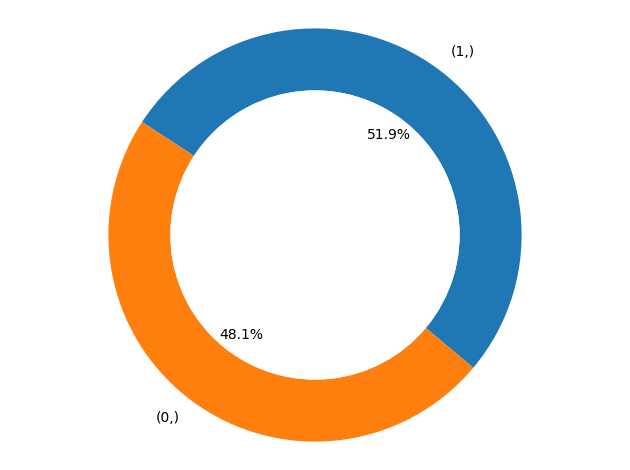

In [47]:
import matplotlib.pyplot as plt

# Get the values and labels for the pie chart.
values = y_test_prediction.value_counts().values.tolist()
labels = y_test_prediction.value_counts().index.to_list()

# Create the pie chart.
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=-40, wedgeprops=dict(width=0.3))

# Add a white circle in the middle to make the pie chart look like a donut.
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie chart is drawn as a circle.
ax.axis('equal')

# Show the pie chart.
plt.tight_layout()
plt.show()

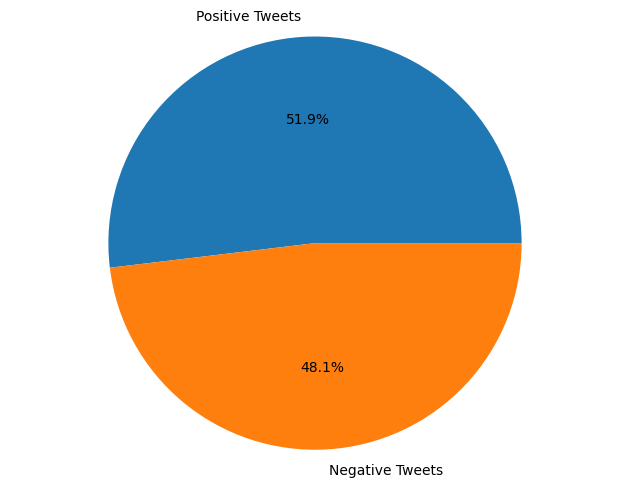

In [57]:
import matplotlib.pyplot as plt

# Get the values and labels for the pie chart.
values = y_test_prediction.value_counts().values.tolist()
#labels = y_test_prediction.value_counts().index.to_list()
labels = ["Positive Tweets", "Negative Tweets"]

# Create the pie chart.
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%")

# Equal aspect ratio ensures that pie chart is drawn as a circle.
ax.axis('equal')

# Show the pie chart.
plt.tight_layout()
plt.show()

## **Saving the Trained Model**

In [49]:
import pickle

In [50]:
fiename = 'trained_model.sav'
pickle.dump(model, open(fiename, 'wb'))

## **Using the Saved Model for Future Predictions**

In [51]:
#Loading the saved Model
loaded_model = pickle.load(open('/content/trained_model.sav', 'rb'))

In [52]:
X_new = X_test[200]
print(X_new)

  (0, 425173)	0.4861797169777241
  (0, 400002)	0.33425960056335163
  (0, 387466)	0.46923185113800253
  (0, 372988)	0.3474823166340872
  (0, 326966)	0.3047343739770557
  (0, 242268)	0.20103456365786704
  (0, 145988)	0.18586475941913905
  (0, 127090)	0.32853785623524473
  (0, 93795)	0.18766071909970514


In [53]:
print(y_test[200])

1


In [54]:
prediction = model.predict(X_new)
print(prediction)

[1]


In [55]:
if (prediction[0]==0):
  print("Negative Tweet")
else:
  print("Positive Tweet")

Positive Tweet


In [56]:
X_new = X_test[3]
print(y_test[3])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print("Negative Tweet")
else:
  print("Positive Tweet")

0
[0]
Negative Tweet
